In [5]:
%reset

import numpy as np
import matplotlib.pyplot as pl
import pdb

import pickle as pk
import numpy as np

from scipy import stats
from scipy import special
from scipy import interpolate

from PIL import Image

import os

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## The code below generates the solution for problem 1

In [6]:
from scipy.integrate import quad

def get_dndL(L, L_star, alpha):
    dndL = (1./L_star)*((L/L_star)**alpha)*np.exp(-L/L_star)
    return dndL

def get_normalized_dndL(L, L_star, alpha, L_min):
    # Integrate over a grid to determine normalization
    numL = 10000
    L_arr = np.linspace(L_min, maxL, num = numL)
    dL = L_arr[1:] - L_arr[:-1]
    dndL_grid = get_dndL(L_arr, L_star, alpha)
    norm = np.sum(0.5*dL*(dndL_grid[1:] + dndL_grid[:-1]))
    
    #Get normalized dndL
    dndL_unnormalized = get_dndL(L, L_star, alpha)
    dndL_normalized = (1./norm)*dndL_unnormalized
    
    return dndL_normalized

# Function to compute posterior
def get_lnposterior(L, L_star, alpha, L_min, prior_type):
    dndL = get_normalized_dndL(L, L_star, alpha, L_min)
    
    if (prior_type == 'flat'):
        lnprior = 0.
    if (prior_type == 'logflat'):
        lnprior = np.log(1./L_star)
    
    lnlike = np.sum(np.log(dndL))
    #lnlike_test = get_lnliketest(L, L_star, alpha)    
    lnpost = lnprior+lnlike

    return lnpost

In [9]:
#load data
data = np.genfromtxt('galaxy_lum.dat')

#Maximum luminosity to consider - set this high enough that it doesn't matter
maxL = 50.

# Evaluate posterior
min_Lstar = 0.01
max_Lstar = 4.0
num_Lstar = 50
Lstar_arr = np.linspace(min_Lstar, max_Lstar, num = num_Lstar)

min_alpha = -2.5
max_alpha = 0.0
num_alpha = 51
alpha_arr = np.linspace(min_alpha, max_alpha, num = num_alpha)

lnpost_arr = np.zeros((num_Lstar, num_alpha))
lnpost_wrongLmin_arr = np.zeros((num_Lstar, num_alpha))
lnpost_diffprior_arr = np.zeros((num_Lstar, num_alpha))

for li in range(0,num_Lstar):
    for ai in range(0,num_alpha):
        lnpost_arr[li,ai] = get_lnposterior(data, Lstar_arr[li], alpha_arr[ai], 1.0, 'flat')
        lnpost_wrongLmin_arr[li,ai] = get_lnposterior(data, Lstar_arr[li], alpha_arr[ai], 0.98, 'flat')
        lnpost_diffprior_arr[li,ai] = get_lnposterior(data, Lstar_arr[li], alpha_arr[ai], 1.0, 'logflat')        
        

<ipython-input-6-6b06cf151e46>:30: RuntimeWarning: divide by zero encountered in log
  lnlike = np.sum(np.log(dndL))


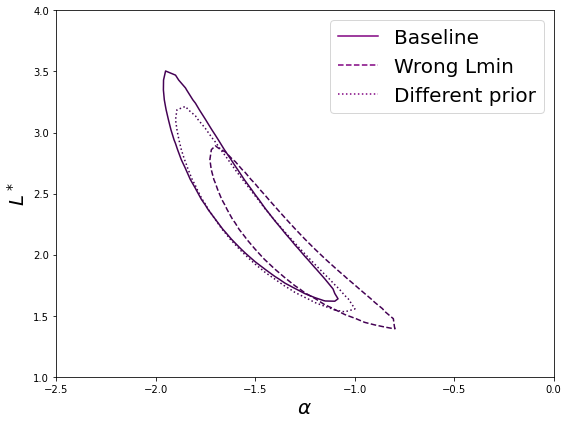

In [10]:
# Make contour plot
def get_contour_level(lnpost_arr, level):
    #requires linear spacing in parameter values
    
    post_arr = np.exp(lnpost_arr - np.max(lnpost_arr))
    post_arr = post_arr/np.sum(post_arr)
    
    #sort values
    pdfsort = np.sort(post_arr.flatten())[::-1]
    cumpdf = np.cumsum(pdfsort)
        
    above_level = np.where(cumpdf > level)[0]
    plevel = pdfsort[above_level[0]-1]
    
    return post_arr, plevel


pval = 0.68
post_arr, level = get_contour_level(lnpost_arr, pval)
post_arr_wrongLmin, level_wrongLmin = get_contour_level(lnpost_wrongLmin_arr, pval)
post_arr_diffprior, level_diffprior = get_contour_level(lnpost_diffprior_arr, pval)
    
fig, ax = pl.subplots(1,1, figsize = (8,6))
ax.contour(alpha_arr, Lstar_arr, post_arr, levels = [level])
ax.contour(alpha_arr, Lstar_arr, post_arr_wrongLmin, levels = [level_wrongLmin], \
           linestyles = 'dashed')
ax.contour(alpha_arr, Lstar_arr, post_arr_diffprior, levels = [level_diffprior], \
           linestyles = 'dotted')
ax.set_xlim((-2.5, 0.))
ax.set_ylim((1., 4.0))

ax.plot([-1., -1], [-1, -1.], label = 'Baseline', color = 'purple')
ax.plot([-1., -1], [-1, -1.], label = 'Wrong Lmin', color = 'purple', ls = 'dashed')
ax.plot([-1., -1], [-1, -1.], label = 'Different prior', color = 'purple', ls = 'dotted')
ax.legend(fontsize = 20)

ax.set_xlabel(r'$\alpha$', fontsize = 20)
ax.set_ylabel(r'$L^*$', fontsize = 20)
fig.tight_layout()
fig.savefig('Schechter_plot.png')

## The code below generates the solution for problem 2

In [17]:
# load data

data = np.genfromtxt('MCMC_datavector.dat')
cov = np.genfromtxt('MCMC_covariance.dat')

#compute inverse covariance, since this will be useful below
invcov = np.linalg.inv(cov)


In [18]:
def get_model(params):
    return params

def lnpost(params, data):
    #calculate prior
    lnprior = 0.
    if ((np.min(params) < -30.) or (np.max(params) > 30.)):
        lnprior = -1.0e100 #set to very negative number
    
    #calculate likelihood
    model = get_model(params)
    N_data = data.shape[0]
    lnlike = 0.
    for ii in range(0,N_data):
        diff = data[ii,:] - model
        lnlike += -0.5*np.dot(diff, np.dot(invcov, diff))
    
    #calculate posterior
    lnpost = lnprior + lnlike
    return lnpost

In [20]:
# MCMC

def proposal(x_0, jump_size):
    dim = len(x_0)
    cov = np.diag(np.zeros(dim)+jump_size**2.)
    x1 = np.random.multivariate_normal(x_0, cov)
        
    return x1

def run_mcmc(x_0, N_steps, lnpost_func, data, jump_size):
    dim = len(x_0)
    
    chain = np.zeros((N_steps, dim))
    chain[0,:]  = x_0
    npts = 1
    
    x_current = np.copy(x_0)
    lnpost_current = lnpost(x_current, data)
    num_accepted = 0
    while (npts < N_steps):
        if (npts % 1000 == 0):           
            print("npts = ", npts)
        x_proposal = proposal(x_current, jump_size)
        lnpost_proposal = lnpost(x_proposal, data)
        post_ratio = np.exp(lnpost_proposal - lnpost_current)
        randu = np.random.rand()
        if (randu < post_ratio):
            chain[npts,:] = x_proposal
            x_current = x_proposal
            lnpost_current = lnpost_proposal
            npts += 1
            num_accepted += 1
        else:
            chain[npts,:] = x_current         
            npts = npts+1
            continue
    
    acceptance_fraction = 1.0*num_accepted/N_steps
    return chain, acceptance_fraction

N_steps = 15000

#intial parameter guess
x_0 = np.zeros(data.shape[1])

chain, acceptance_frac = run_mcmc(x_0, N_steps, lnpost, data, 0.05)
print("acceptance fraction = ", acceptance_frac)


npts =  1000
npts =  2000
npts =  3000
npts =  4000
npts =  5000
npts =  6000
npts =  7000
npts =  8000
npts =  9000
npts =  10000
npts =  11000
npts =  12000
npts =  13000
npts =  14000
acceptance fraction =  0.3572


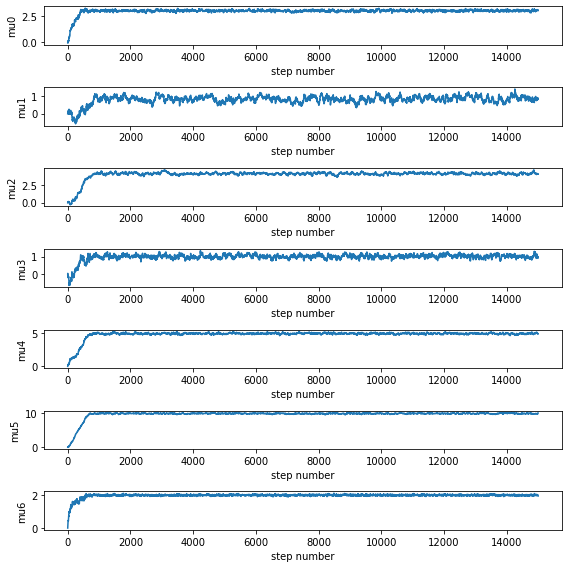

In [21]:
# MCMC diagnostics

fig, ax = pl.subplots(len(x_0),1, figsize = (8,8))
for ii in range(len(x_0)):
    ax[ii].plot(chain[:,ii])
    ax[ii].set_ylabel('mu{}'.format(ii))
    ax[ii].set_xlabel('step number')
fig.tight_layout()

fig.savefig('mcmc_1.png')
    


Removed no burn in


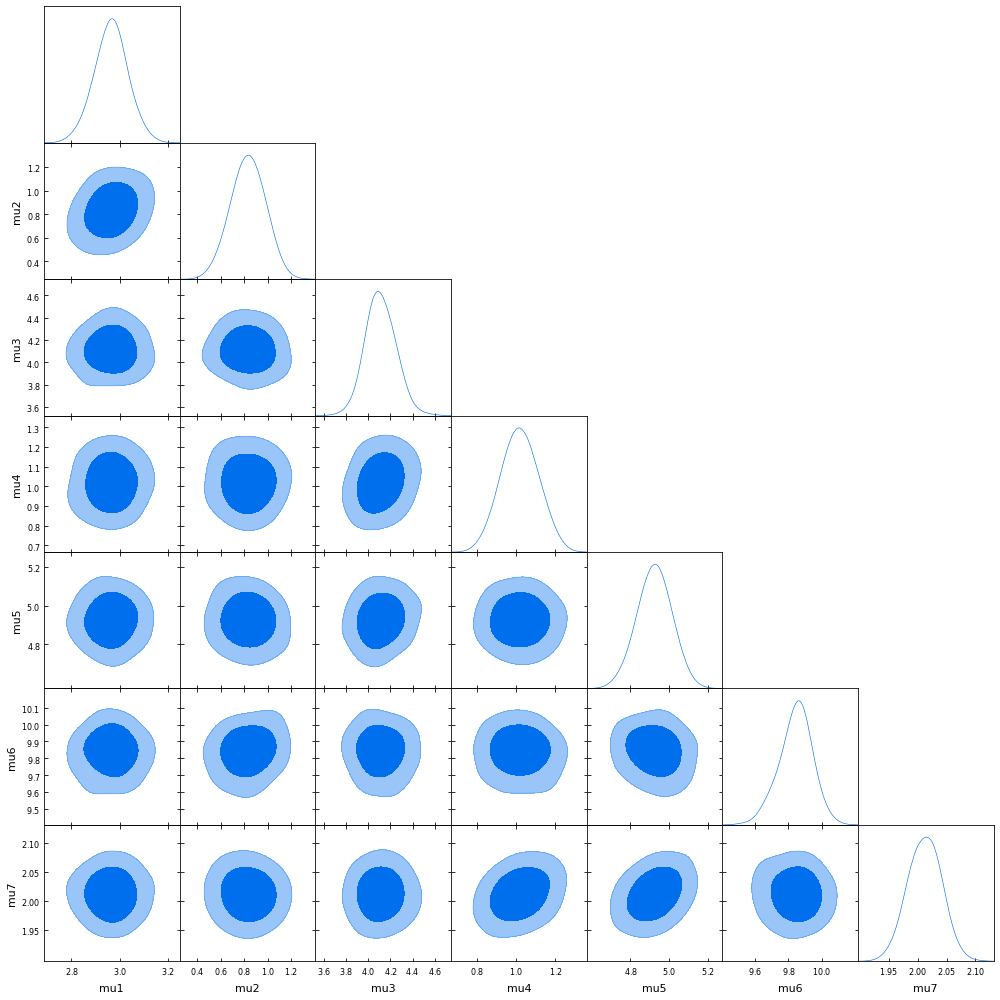

In [22]:
from getdist import plots, MCSamples

burnin = 3000
names = ['mu1','mu2','mu3','mu4','mu5','mu6','mu7']
samples = MCSamples(samples=chain[burnin:,:], names = names)
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True)

g.export('mcmc_2.png')


In [23]:
# compute credible intervals

for ii in range(0,len(x_0)):
    print("95\% interval for mu {} = ({}, {})".format(ii+1,np.percentile(chain[burnin:,ii], 2.5),\
                                                      np.percentile(chain[burnin:,ii],97.5)))

95\% interval for mu 1 = (2.821108546554794, 3.103308944923386)
95\% interval for mu 2 = (0.5347012638387126, 1.1179137104249677)
95\% interval for mu 3 = (3.8385283959881553, 4.387145158599101)
95\% interval for mu 4 = (0.8247736658626525, 1.2126641813629013)
95\% interval for mu 5 = (4.738805473069361, 5.0999756351402805)
95\% interval for mu 6 = (9.627762842692555, 10.03737006675457)
95\% interval for mu 7 = (1.9519888187569208, 2.070197576564984)


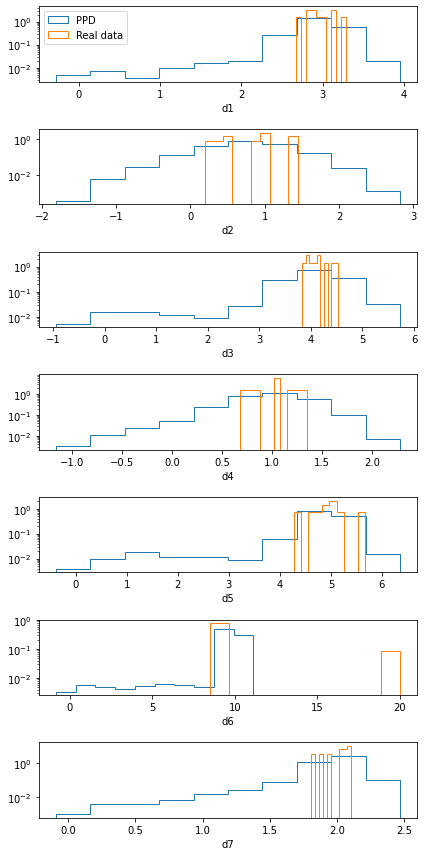

In [24]:
# Posterior predictive distribution checks
N_rep = chain[burnin:,ii].shape[0]
len_data = chain.shape[1]
d_rep = np.zeros((N_rep, len_data))

for ii in range(0, N_rep):
    #Generate a random realization of the data at this point in parameter space
    params_i = chain[ii,:]
    d_repi = np.random.multivariate_normal(params_i, cov)
    #Save the mock data
    d_rep[ii,:] = d_repi

fig, ax = pl.subplots(len_data,1, figsize = (6,12))
for ii in range(0,len_data):
    ax[ii].hist(d_rep[:,ii], histtype = 'step', density = True, label = 'PPD')
    ax[ii].hist(data[:,ii], histtype = 'step', density = True, label = 'Real data')
    ax[ii].set_yscale('log')
    ax[ii].set_xlabel('d{}'.format(ii+1))
fig.tight_layout()
ax[0].legend(loc = 'upper left')
fig.savefig('ppd_check.png')

## The code below generates the solution for problem 3

In [3]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

# load in data
directory = '../../Galaxy_images/'
filenames = os.listdir(directory)

dim = 424
reduced_dim = 40

N_files = 10000
all_data = np.zeros((N_files, reduced_dim**2))
for ii, fi in enumerate(filenames[0:N_files]):
    image = np.asarray(Image.open(directory + fi))
    
    #rebin to lower resolution array
    image_rebin = rebin(image[:,:,0],[int(dim/4), int(dim/4)])
    
    new_dims = image_rebin.shape
    min_index = int(new_dims[0]/2 - reduced_dim/2)
    max_index = int(new_dims[0]/2 + reduced_dim/2)
    image_cut = image_rebin[min_index:max_index, min_index:max_index]

    #fig, ax = pl.subplots(1,1)
    #ax.imshow(image_rebin)
    
    #fig, ax = pl.subplots(1,1)
    #ax.imshow(image_cut)
    
    all_data[ii,:] = image_cut.flatten()

In [33]:
# compute PCs
cov = np.cov(all_data.transpose())
print(cov.shape)
uu, vv = np.linalg.eig(cov)


(1600, 1600)


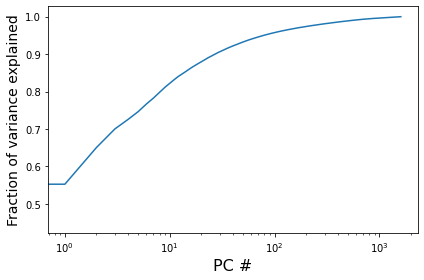

In [34]:
fig, ax = pl.subplots(1,1)
ax.plot(np.cumsum(uu)/np.sum(uu))
ax.set_xscale('log')
ax.set_xlabel('PC #', fontsize = 16)
ax.set_ylabel('Fraction of variance explained', fontsize = 14)

fig.tight_layout()
fig.savefig('pc_1.png')

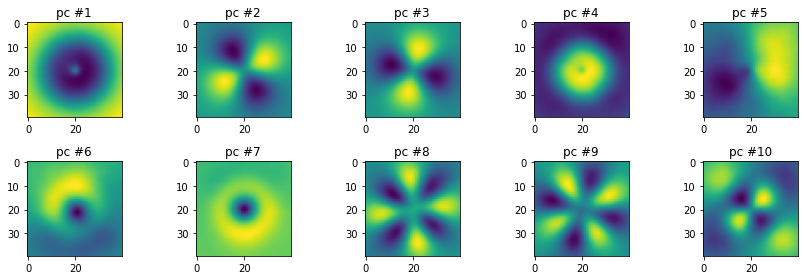

In [35]:
N_pcs = 10

fig, ax = pl.subplots(2, int(N_pcs/2), figsize = (12,4))
pci = 0
for jj in range(0,2):
    for ii in range(0,int(N_pcs/2)):
        ax[jj,ii].imshow(vv[:,pci].reshape(reduced_dim, reduced_dim))
        pci += 1
        ax[jj,ii].set_title('pc #{}'.format(pci))
fig.tight_layout()
fig.savefig('pc_2.png')

In [36]:
# Project galaxies onto PCs
top_pcs = vv[:,0:N_pcs]
projection = np.matmul(all_data, top_pcs)

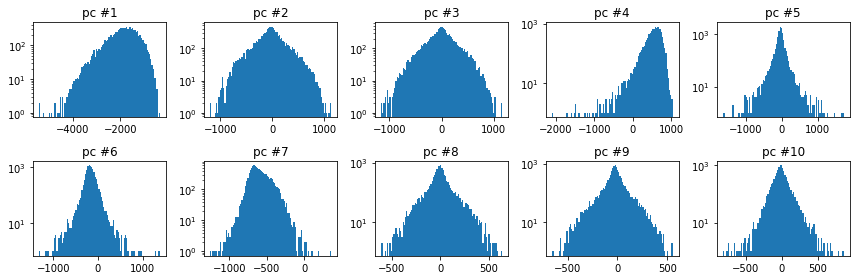

In [37]:
N_plot = N_pcs

fig, ax = pl.subplots(2, int(N_pcs/2), figsize = (12,4))
pci = 0
for jj in range(0,2):
    for ii in range(0,int(N_pcs/2)):
        ax[jj,ii].hist(projection[:,pci], bins = 100)
        pci += 1
        ax[jj,ii].set_yscale('log')
        ax[jj,ii].set_title('pc #{}'.format(pci))
fig.tight_layout()
fig.savefig('pc_3.png')        

[ 602 1372 1771 2313 3802 4445 5866 6526 6561 7456 7641 7969 8499 8731
 9815]


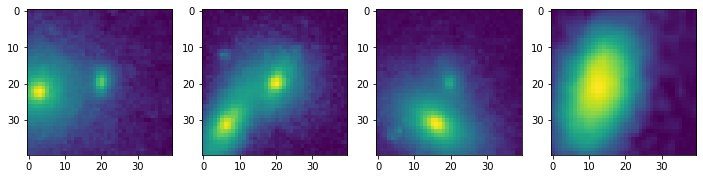

In [38]:
# Identify unusual galaxies
weird = np.where(projection[:,4] < -1000)[0]
print(weird)
fig, ax = pl.subplots(1,4, figsize = (12,4))
for ii in range(0,4):
    ax[ii].imshow(all_data[weird[ii],:].reshape(reduced_dim, reduced_dim))
fig.savefig('pc_4.png')        

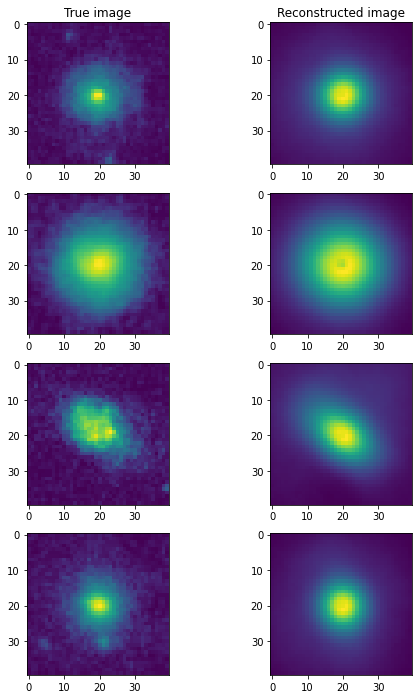

In [39]:
N_gal = 4
fig, ax = pl.subplots(N_gal,2, figsize = (8,12))
for ii in range(0,N_gal):
    reconstruct = np.matmul(vv[:,0:N_pcs], projection[ii,:])
    ax[ii,0].imshow(all_data[ii,:].reshape(reduced_dim, reduced_dim))
    ax[ii,1].imshow(reconstruct.reshape(reduced_dim, reduced_dim))
ax[0,0].set_title('True image')
ax[0,1].set_title('Reconstructed image')
fig.savefig('pc_5.png')        